In [13]:
#Importing required library for the ML model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score,KFold
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import make_classification

In [5]:
# Define the classifiers
classifiers = {
    'Linear SVC': LinearSVC(dual='auto', max_iter=10000),
    'Logistic Regression': LogisticRegression(solver='saga', max_iter=10000),
    'Naive Bayes': GaussianNB(),
    'Bagging': BaggingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

In [6]:
# Define the outer cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
# Initialize lists to store mean and standard deviation of outer scores for each classifier
mean_outer_scores = []
std_outer_scores = []

In [8]:
#import data file
bank_data = pd.read_csv('bank-additional-full.csv', delimiter = ';')

In [12]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [9]:
# Separate features and target
X = bank_data.drop('y', axis=1)
y = bank_data['y'].map({'no': 0, 'yes': 1})

In [10]:
# Encode categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
X[categorical_cols] = X[categorical_cols].apply(lambda x: x.astype('category').cat.codes)

In [11]:
# Perform nested cross-validation for each classifier
for classifier_name, classifier in classifiers.items():
    outer_scores = []
    for train_idx, test_idx in outer_cv.split(X):
        X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
        y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

        # Define the inner cross-validation
        inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

        # Perform inner cross-validation to tune hyperparameters
        inner_scores = cross_val_score(classifier, X_train_outer, y_train_outer, cv=inner_cv, scoring='accuracy')

        # Select the best hyperparameters
        best_score_idx = np.argmax(inner_scores)
        best_params = inner_scores[best_score_idx]

        # Train the model on the entire training data with the best hyperparameters
        classifier.fit(X_train_outer, y_train_outer)

        # Evaluate the model on the test data
        test_score = classifier.score(X_test_outer, y_test_outer)
        outer_scores.append(test_score)

    # Calculate and print the mean and standard deviation of the outer scores for each classifier
    mean_outer_score = np.mean(outer_scores)
    std_outer_score = np.std(outer_scores)
    print(f"{classifier_name}: Mean Outer CV Score: {mean_outer_score:.4f} +/- {std_outer_score:.4f}")

    # Store mean and standard deviation of outer scores
    mean_outer_scores.append(mean_outer_score)
    std_outer_scores.append(std_outer_score)

Linear SVC: Mean Outer CV Score: 0.9076 +/- 0.0037
Logistic Regression: Mean Outer CV Score: 0.9076 +/- 0.0024
Naive Bayes: Mean Outer CV Score: 0.8464 +/- 0.0043
Bagging: Mean Outer CV Score: 0.9088 +/- 0.0017
AdaBoost: Mean Outer CV Score: 0.9095 +/- 0.0021
Random Forest: Mean Outer CV Score: 0.9148 +/- 0.0020


Model performance is measured using a method called cross-validation (CV), which assesses how well a model will generalize to an independent data set.

Here's a summary of the results:

1. **Random Forest**: This model has the highest mean CV score of **0.9148** with a standard deviation of **0.0020**. This means it performed the best on average and its performance was consistent across different subsets of the data.

2. **AdaBoost**: This model has the second highest mean CV score of **0.9095** with a standard deviation of **0.0021**.

3. **Linear SVC**, **Logistic Regression**, and **Bagging**: These models all have similar mean CV scores around **0.9076**, but with different standard deviations. The Bagging model has the smallest standard deviation (**0.0017**), indicating it's the most consistent among these three.

4. **Naive Bayes**: This model has the lowest mean CV score of **0.8464** with a standard deviation of **0.0043**, indicating it performed the worst on average and its performance varied the most across different subsets of the data.

In conclusion, based on these results, the Random Forest model performed the best, while the Naive Bayes model performed the worst. However, it's important to note that these rankings are based solely on the mean CV scores and their standard deviations. Other factors such as the nature of the data, the interpretability of the model, and the computational efficiency might also influence which model is considered "best" or "least effective" in a given situation.

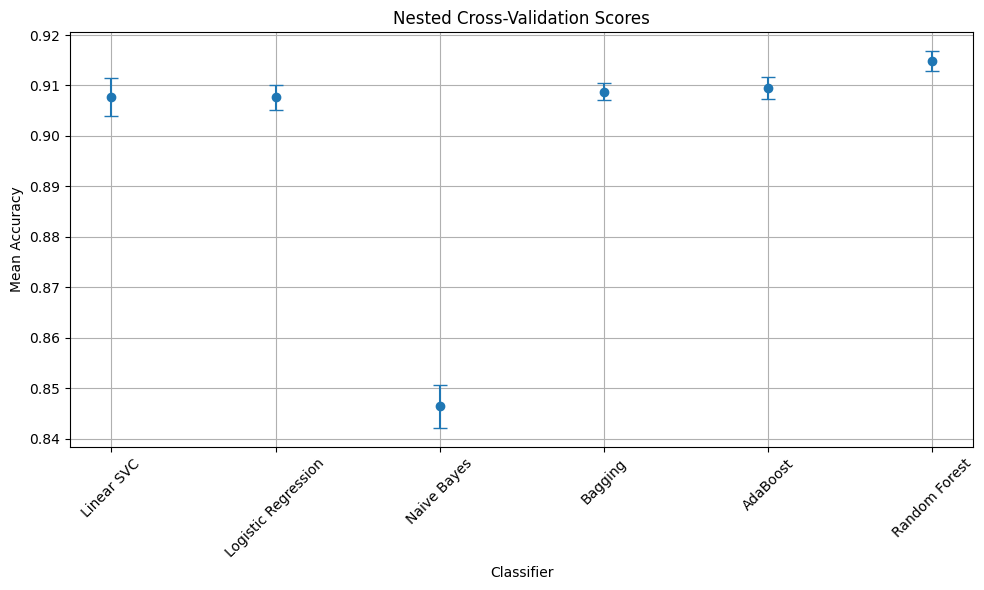

In [17]:
# Plot the Nested Cross-Validation Scores chart
plt.figure(figsize=(10, 6))
plt.errorbar(classifiers.keys(), mean_outer_scores, yerr=std_outer_scores, fmt='o', capsize=5)
plt.xlabel('Classifier')
plt.ylabel('Mean Accuracy')
plt.title('Nested Cross-Validation Scores')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [19]:
# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
# Make predictions on train, validation, and test sets
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

In [22]:
# Evaluate on various metrics
print('Train set performance:')
print(f'Accuracy: {accuracy_score(y_train, train_preds):.4f}')
print(f'Precision: {precision_score(y_train, train_preds):.4f}')
print(f'Recall: {recall_score(y_train, train_preds):.4f}')
print(f'F1-score: {f1_score(y_train, train_preds):.4f}')
print(f'ROC AUC: {roc_auc_score(y_train, train_preds):.4f}')

print('\nValidation set performance:')
print(f'Accuracy: {accuracy_score(y_val, val_preds):.4f}')
print(f'Precision: {precision_score(y_val, val_preds):.4f}')
print(f'Recall: {recall_score(y_val, val_preds):.4f}')
print(f'F1-score: {f1_score(y_val, val_preds):.4f}')
print(f'ROC AUC: {roc_auc_score(y_val, val_preds):.4f}')

print('\nTest set performance:')
print(f'Accuracy: {accuracy_score(y_test, test_preds):.4f}')
print(f'Precision: {precision_score(y_test, test_preds):.4f}')
print(f'Recall: {recall_score(y_test, test_preds):.4f}')
print(f'F1-score: {f1_score(y_test, test_preds):.4f}')
print(f'ROC AUC: {roc_auc_score(y_test, test_preds):.4f}')

Train set performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000

Validation set performance:
Accuracy: 0.9143
Precision: 0.6492
Recall: 0.5189
F1-score: 0.5768
ROC AUC: 0.7417

Test set performance:
Accuracy: 0.9120
Precision: 0.6404
Recall: 0.5123
F1-score: 0.5692
ROC AUC: 0.7377


In [23]:
#predict the probabilities of the possible outcomes for the test dataset X_test
test_probs = model.predict_proba(X_test)[:, 1]

In [24]:
# Calculate false positive rates and true positive rates
fpr, tpr, thresholds = roc_curve(y_test, test_probs)

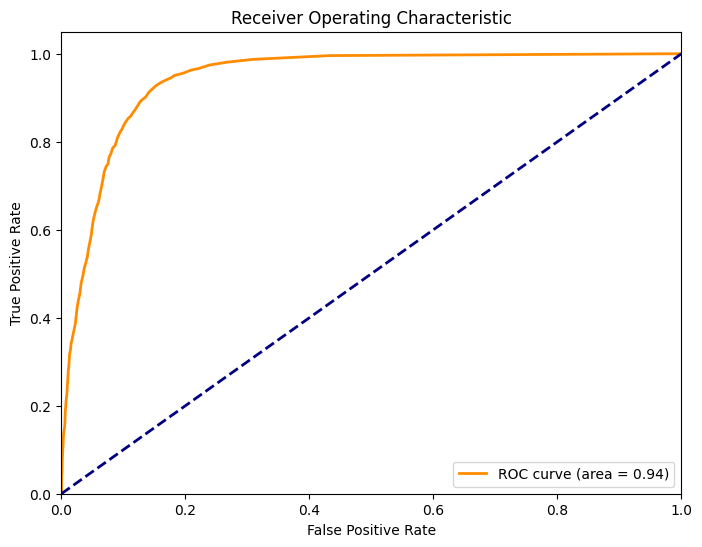

In [25]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, test_probs))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [26]:
# Evaluation metrics for the test set
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']
values = [accuracy_score(y_test, test_preds),
          precision_score(y_test, test_preds),
          recall_score(y_test, test_preds),
          f1_score(y_test, test_preds),
          roc_auc_score(y_test, test_preds)]

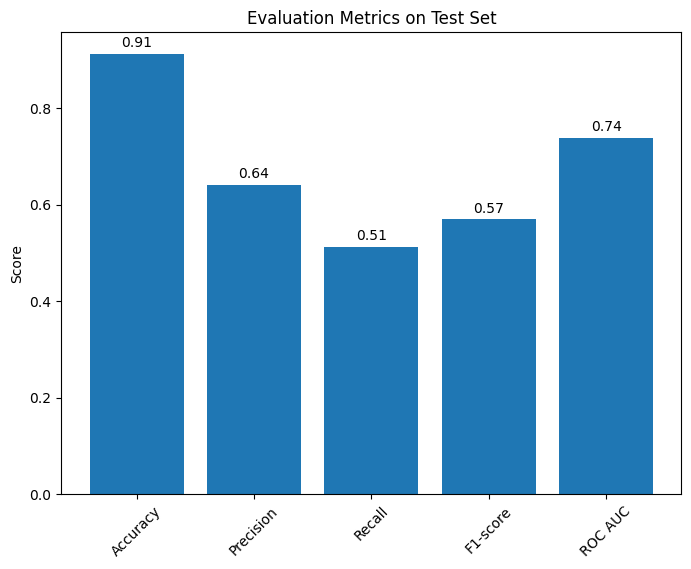

In [27]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Create the bar chart
x = np.arange(len(metrics))
bars = ax.bar(x, values)

# Add data labels
for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.2f}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
# Add labels and title
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics on Test Set')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()

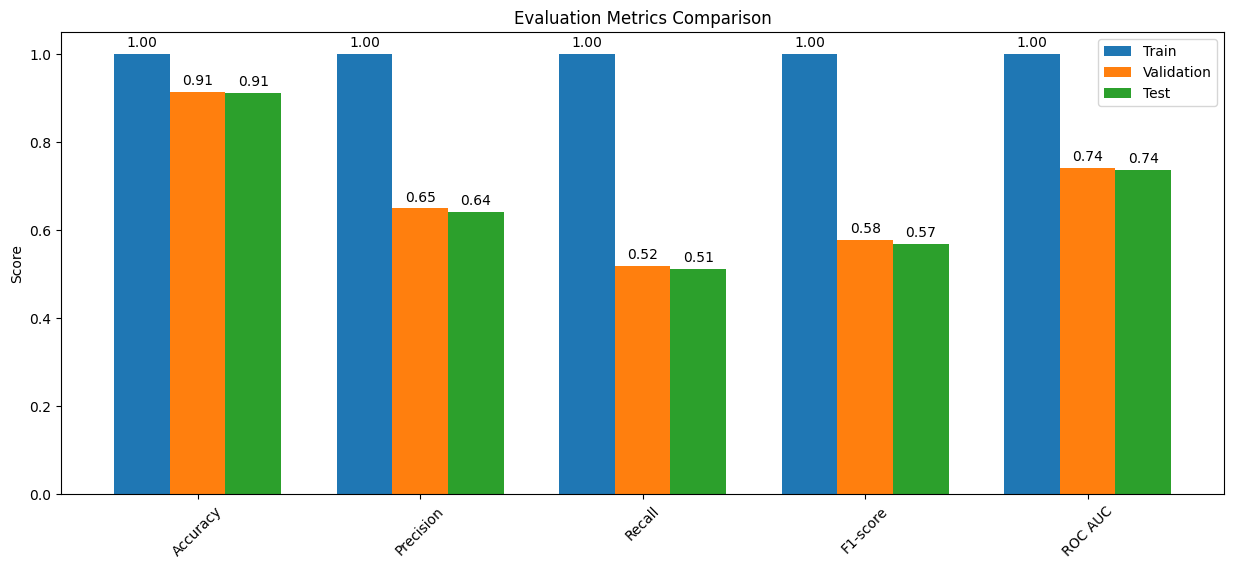

In [28]:
# Evaluation metrics for train, validation, and test sets
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']
train_values = [accuracy_score(y_train, train_preds),
                precision_score(y_train, train_preds),
                recall_score(y_train, train_preds),
                f1_score(y_train, train_preds),
                roc_auc_score(y_train, train_preds)]

val_values = [accuracy_score(y_val, val_preds),
              precision_score(y_val, val_preds),
              recall_score(y_val, val_preds),
              f1_score(y_val, val_preds),
              roc_auc_score(y_val, val_preds)]

test_values = [accuracy_score(y_test, test_preds),
               precision_score(y_test, test_preds),
               recall_score(y_test, test_preds),
               f1_score(y_test, test_preds),
               roc_auc_score(y_test, test_preds)]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(15, 6))

# Set the bar width and positions
bar_width = 0.25
x = np.arange(len(metrics))

# Create the bars
bars1 = ax.bar(x - bar_width, train_values, bar_width, label='Train')
bars2 = ax.bar(x, val_values, bar_width, label='Validation')
bars3 = ax.bar(x + bar_width, test_values, bar_width, label='Test')

# Add data labels
for bars, values in zip([bars1, bars2, bars3], [train_values, val_values, test_values]):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels and title
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics Comparison')
ax.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()